# Анализ данных для  «Стримчик»

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). **Нужно выявить определяющие успешность игры закономерности.** Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Оглавление:**

- [Предобработка-данных](#Предобработка-данных)

- [EDA](#EDA)

- [Портрет пользователя каждого региона](#Портрет-пользователя-каждого-региона)

- [Проверка гипотез](#Проверка-гипотез)

- [Общий вывод](#Общий-вывод)

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import requests
import re
from bs4 import BeautifulSoup
import random
from scipy import stats as st
import time

In [2]:
df = pd.read_csv('datasets/games.csv')

In [3]:
df.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df.describe()

Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000

- Name — название игры

- Platform — платформа

- Year_of_Release — год выпуска

- Genre — жанр игры

- NA_sales — продажи в Северной Америке (миллионы проданных копий)

- EU_sales — продажи в Европе (миллионы проданных копий)

- JP_sales — продажи в Японии (миллионы проданных копий)

- Other_sales — продажи в других странах (миллионы проданных копий)

- Critic_Score — оценка критиков (максимум 100)

- User_Score — оценка пользователей (максимум 10)

- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Выполним следующие действия:

- Приведем названия столбцов к нижнему регистру

- Удалим строки, для которых не указано название игры (таких только 2, поэтому это не повлияет на результаты анализа)

- Заполним пропущенные значения в столбце year_of_release данными из интернета

- Преобразуем year_of_release к типу integer, т.к. год не может быть десятичным

- Разделим critic_score на 10, чтобы critic_score и user_scoreимели одинаковый диапазон

In [6]:
# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [7]:
# Удалим строки, для которых не указано название игры 
df.dropna(subset=['name'], inplace=True)
df.reset_index(inplace=True,drop=True)

In [8]:
# Заполним пропущенные значения в столбце year_of_release данными из интернета
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:78.0)   Gecko/20100101 Firefox/78.0", 
"Referer": "https://www.google.com"}

for i in range(0, len(df)):
    if pd.isnull(df.loc[i, 'year_of_release']):
        URL = 'https://www.google.com/search?q={' + df['name'][i].replace(' ', '+') + '+' + df['platform'][i] + '+' + 'release+year}&hl={en}'
        #URL = 'https://yandex.ru/search/?text=' + df['name'][i].replace(' ', '+') + '+' + df['platform'][i] + '+' + 'release+year&lr=198'
        req = requests.get(URL, headers=headers)
        soup = BeautifulSoup(req.text, 'lxml') 
        year = 0
        txt = ''
        for div in soup.find_all('div'):
            txt += div.text
        #print(txt)
        year = re.search('Release[A-Za-z0-9 .:,()]*[1-2][09][0-9][0-9]', txt)
        #year = re.search('[1-2][09][0-9][0-9]', txt)
        if pd.isnull(year) == False:
            year = year.group()
            year = re.search('[1-2][09][0-9][0-9]', year).group()
            year = int(year)
            if year <= 2017 and year > 1950:
                df.loc[i, 'year_of_release'] = year

In [9]:
df[df['year_of_release'].isna()]

name platform  year_of_release  \
8196                   NBA Starting Five      PS2              NaN   
8211                         Teen Titans      GBA              NaN   
8249                         Trauma Team      Wii              NaN   
8259                         Backbreaker      PS3              NaN   
8318          James Cameron's Dark Angel      PS2              NaN   
...                                  ...      ...              ...   
16371  PDC World Championship Darts 2008      PSP              NaN   
16403                      Freaky Flyers       GC              NaN   
16446                          Inversion       PC              NaN   
16456        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16520                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
8196         Sports      0.09      0.07      0.00         0.02          53.0   
8211         Action      0.13      0.05      0.00         0.00          61.0   
8249     Simulation      0.14      0.00      0.02         0.01          82.0   
8259         Sports      0.16      0.00      0.00         0.01          58.0   
8318         Action      0.08      0.07      0.00         0.02          48.0   
...             ...       ...       ...       ...          ...           ...   
16371        Sports      0.01      0.00      0.00         0.00          43.0   
16403        Racing      0.01      0.00      0.00         0.00          69.0   
16446       Shooter      0.01      0.00      0.00         0.00          59.0   
16456     Adventure      0.01      0.00      0.00         0.00           NaN   
16520  Role-Playing      0.01      0.00      0.00         0.00          55.0   

      user_score rating  
8196         7.3      E  
8211         tbd   E10+  
8249         8.8      T  
8259           7      E  
8318         6.5      T  
...          ...    ...  
16371        tbd   E10+  
16403        6.5      T  
16446        6.7      M  
16456        NaN    NaN  
16520        5.5      T  

[142 rows x 11 columns]

In [10]:
# Заполним пропущенные значения вручную
df.loc[3080, 'year_of_release'] = 2011
df.loc[718, 'year_of_release'] = 2006
df.loc[6132, 'year_of_release'] = 2005
df.loc[4817, 'year_of_release'] = 2011
df.loc[6254, 'year_of_release'] = 2004
df.loc[9705, 'year_of_release'] = 2013
df.loc[11432, 'year_of_release'] = 2008
df.loc[13780, 'year_of_release'] = 2008
df.loc[14683, 'year_of_release'] = 2010
df.loc[15077, 'year_of_release'] = 2006
df.loc[15117, 'year_of_release'] = 2009
df.loc[16178, 'year_of_release'] = 2010
df.loc[16456, 'year_of_release'] = 2008
df.loc[15955, 'year_of_release'] = 2010
df.loc[15814, 'year_of_release'] = 2005

In [11]:
# Удалим строки, для которых не получилось найти дату
df.dropna(subset=['year_of_release'], inplace=True)
df.reset_index(inplace=True,drop=True)
# Преобразуем year_of_release к типу integer
df['year_of_release'] = df['year_of_release'].astype('int')
# одинаковый диапазон
df['critic_score'] = df['critic_score'] / 10
# заменим tbd на NaN
df['user_score'] = df['user_score'].replace('tbd', np.NaN)

'tbd' означает 'to be determined', что, в свою очередь, означает, что оценки еще не были выставлены.

user_score и critic_score в большинстве случаев должны быть примерно одинаковыми с небольшими различиями, поэтому для каждой игры заменим пропущенные значения либо user_score, либо critic_score, смотря какое значение присутствует. Пропуски в данных столбцах, могут быть вызваны отсутствием данных.

In [12]:
# заполним пропуски в critic_score or user_score 
for i in range(0, len(df)):
    if(not pd.isnull(df['critic_score'][i])):
        if(pd.isnull(df['user_score'][i])):
            # различие в рейтингах пользователей и критиков
            tmp = random.uniform(-1, 1)
            df.loc[i, 'user_score'] = round(df['critic_score'][i] + tmp,2)
    else:
        if(not pd.isnull(df['user_score'][i])):
            tmp = random.uniform(-1, 1)
            df.loc[i, 'critic_score'] = round(float(df['user_score'][i]) + tmp,2)
            
# проверим пропуски
print('Доля пропущенных значений:')
print(round(df.isna().mean(),2))

# преобразуем user_score в десятичную
df['user_score'] = df['user_score'].astype(float)

Доля пропущенных значений:
name               0.00
platform           0.00
year_of_release    0.00
genre              0.00
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score       0.48
user_score         0.48
rating             0.41
dtype: float64


Таким образом, доля пропусков в critic_score, user_score и rating составляет менее 50%.

Посчитаем суммарные продажи во всех регионах и запишем в столбец total_sales.

In [13]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

ESRB основана в 1994, но в датасете присутствуют данные с 1977. Этим можно объяснить пропуски в rating. Кроме того, «E» первоначально назывался «K-A», поэтому заменим значения.

In [14]:
df.loc[df['rating']=='K-A', 'rating'] = 'E'

- «EC» («Early childhood») — Для детей младшего возраста
 
- «E» («Everyone») — Для всех
 
- «E10+» («Everyone 10 and older») — Для всех от 10 лет и старше
 
- «T» («Teen») — Подросткам
 
- «M» («Mature») — Для взрослых
 
- «AO» («Adults Only 18+») — Только для взрослых
 
- «RP» («Rating Pending») — Рейтинг ожидается

Удалим дубликаты, явные и неявные.

In [15]:
print('Явные дубликаты:', len(df[df.duplicated()]), '\n')
ind = df[df.duplicated(['name', 'platform'])].index
df = df.drop(ind)
print('Неявные дубликаты:', len(df[df.duplicated(['name', 'platform'])]))

Явные дубликаты: 0 

Неявные дубликаты: 0


In [16]:
# we don't want new_df pointing to df therefore use copy()
# перезапишем 
new_df = df.copy()

**Вывод:**

- Мы заполнили и удалили некоторые строки с пропущенными значениями. Таким образом, доли пропусков в critic_score, user_score и rating составили менее 50%

- Преобразовали тип данных year_of_release и user_score

- critic_score и user_score имеют одинаковый диапазон

- Избавились от явных и неявных дубликатов (одинаковые имя и платформа)

- Посчитали суммарные продажи

## EDA

In [17]:
sns.set_style("whitegrid")
colors = ['#0460c9', '#e34020', '#ff8000', '#03a356', '#d96aa0', '#d0de66', '#4a7872', '#ae6cd4']

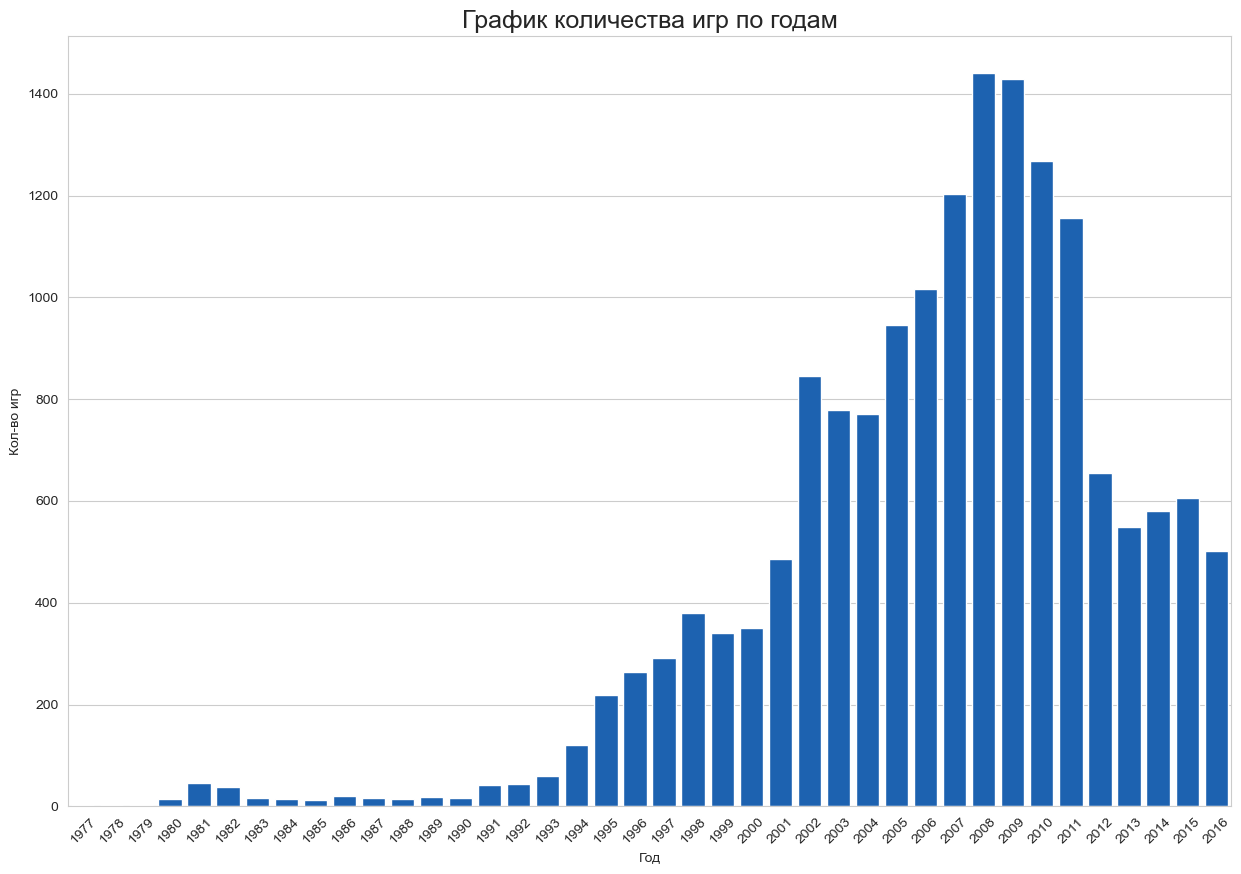

In [18]:
games_by_year = pd.pivot_table(new_df, values='name', index='year_of_release', aggfunc='count').reset_index()

plt.figure(figsize=(15, 10))

sns.barplot(x='year_of_release', y='name', data=games_by_year, color=colors[0])

plt.title('График количества игр по годам', fontsize=18)
plt.xlabel('Год')
plt.ylabel('Кол-во игр')
plt.xticks(rotation=45)
plt.show()

Начиная с 90-х кол-во игр стремительно увеличивалось. В 2012 можно заметить резкий спад. Стоит анализировать данные только за последние несколько лет, т.к. некоторые игровые платформы уже неактуальны, и игры для них не разрабатываются. 

In [19]:
sales_by_platform = (pd.pivot_table(new_df, values='total_sales', index='platform', aggfunc='sum')
                    .reset_index().sort_values(by='total_sales', ascending=False))
print(sales_by_platform.head(8))
top_eight_platforms = list(sales_by_platform['platform'].head(8))

   platform  total_sales
16      PS2      1254.48
28     X360       969.20
17      PS3       938.21
26      Wii       906.32
4        DS       804.68
15       PS       730.57
6       GBA       317.34
18      PS4       314.14


Лидеры продаж среди платформ - PS2 и X360.

In [20]:
def plot_line(dt, palette, ttl):
    
    plt.figure(figsize=(18,10))

    sns.lineplot(data=dt, x="year_of_release", y="total_sales", hue="platform", marker='o', lw=2, palette=palette)

    plt.title(ttl, fontsize=18)
    plt.xlabel('Год')
    plt.ylabel('Продажи, млн.')
    plt.xticks(rotation=45)
    plt.show()

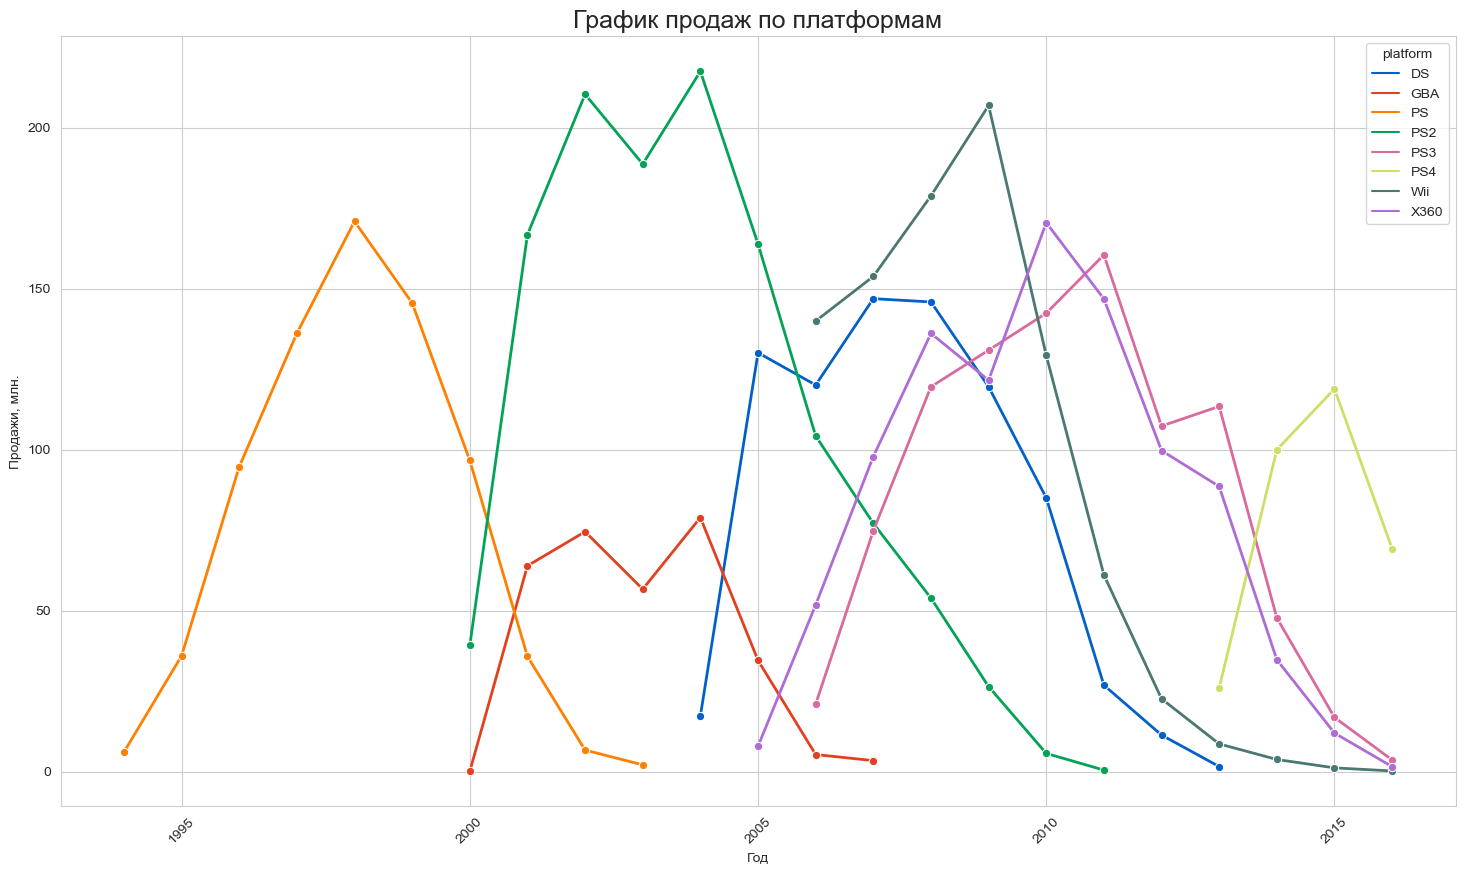

In [21]:
sales_by_platform = (pd.pivot_table(new_df, values='total_sales', index={'year_of_release','platform'}, aggfunc='sum')
                     .reset_index())
sales_by_platform = sales_by_platform[sales_by_platform['platform'].isin(top_eight_platforms)]
    
plot_line(sales_by_platform, colors, 'График продаж по платформам')

"Срок годности" платформы составляет в среднем примерно 10 лет. Поэтому стоит анализировать данные за последние 4-5 лет. Таким образом, платформы, для которых продажи только начали расти, скорее всего покажут положительную тенденцию в будущем. 

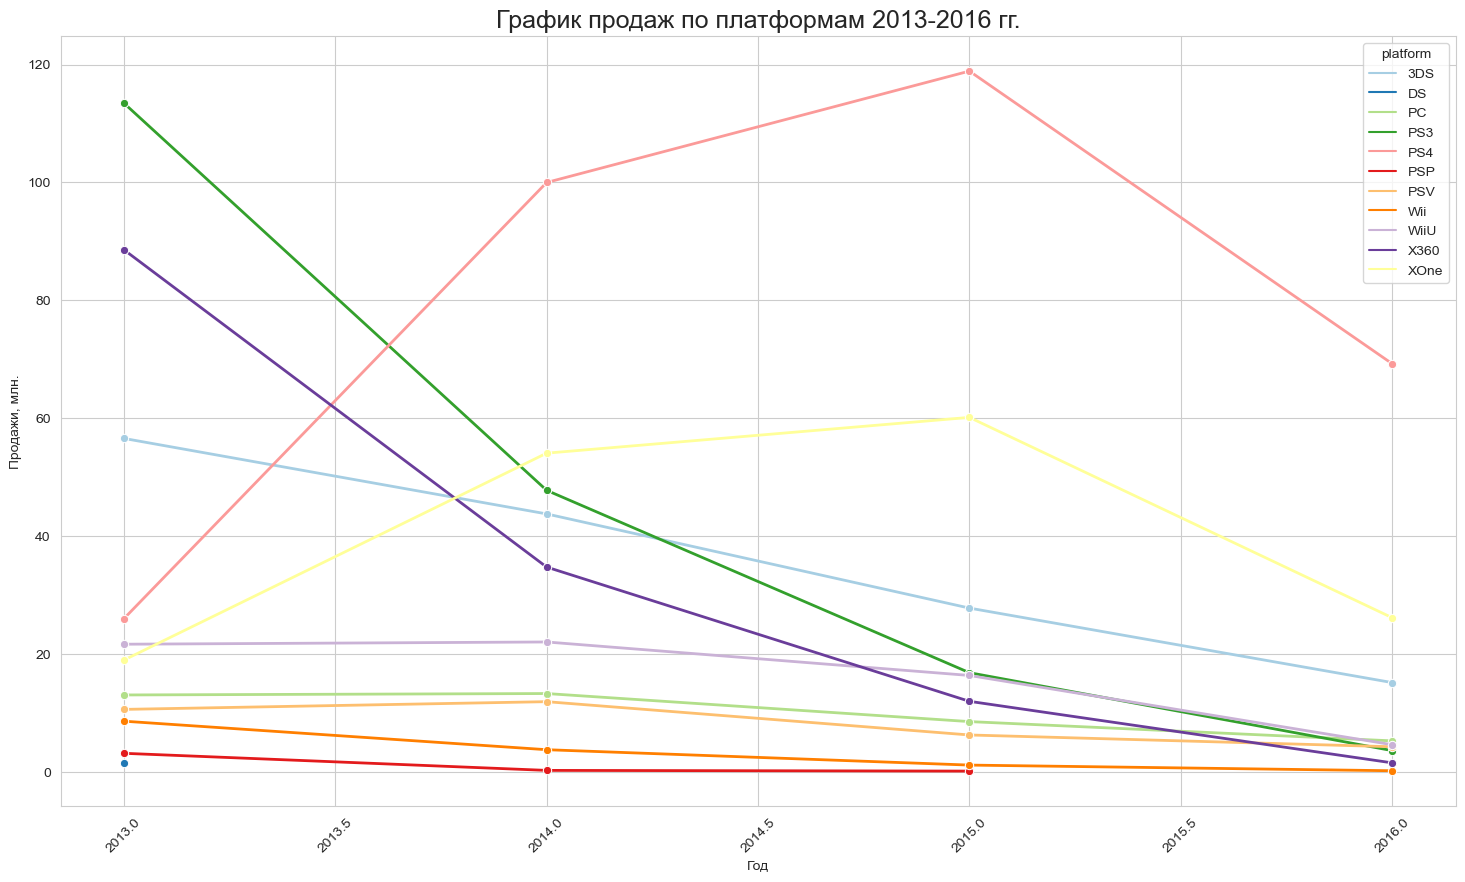

In [22]:
from_2013 = new_df[new_df['year_of_release'] >= 2013].copy()

palette = sns.color_palette('Paired', 11)

sales_by_platform = (pd.pivot_table(from_2013, values='total_sales', index={'year_of_release','platform'}, aggfunc='sum')
                     .reset_index())

plot_line(sales_by_platform, sns.color_palette('Paired', 11), 'График продаж по платформам 2013-2016 гг.')

В начале 2013 PS3 и X360 лидируют по продажам, но ближе к 2014 PS4 выходит на первое место. Небольшое снижение суммарных продаж для данной платформы в 2016 можно объяснить недостатком данных за последний год. Также для остальных платформ спрос минимальный или же его вовсе нет. 

PS4 и Xbox One можно считать потенциально прибыльными.

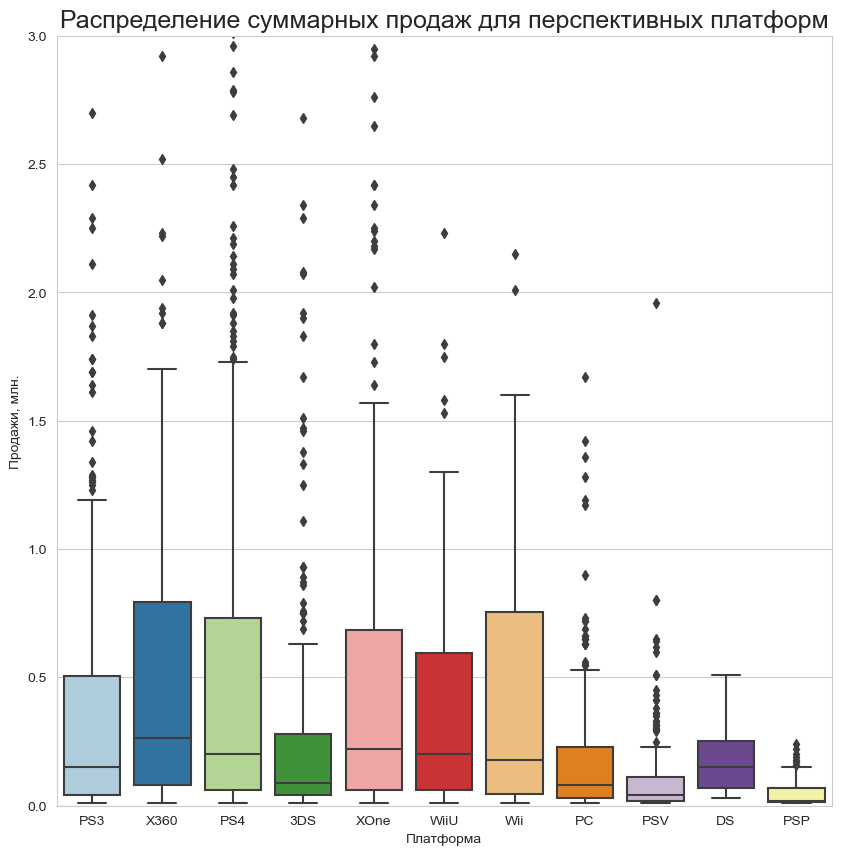

In [23]:
plt.figure(figsize=(10,10))

sns.boxplot(x='platform', y='total_sales', data=from_2013, palette=palette)

plt.ylim([0,3])
plt.title('Распределение суммарных продаж для перспективных платформ', fontsize=18)
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн.')
plt.show()

- Можно заметить, что X360, PS4, PS3, XOne, WiiU, Wii и DS приносят стабильно высокий доход

- Медиана для X360 ~250 000. Для PS4 и XOne ~200 000

- Большое количество выбросов может свидетельствовать о наличии бестселлеров.

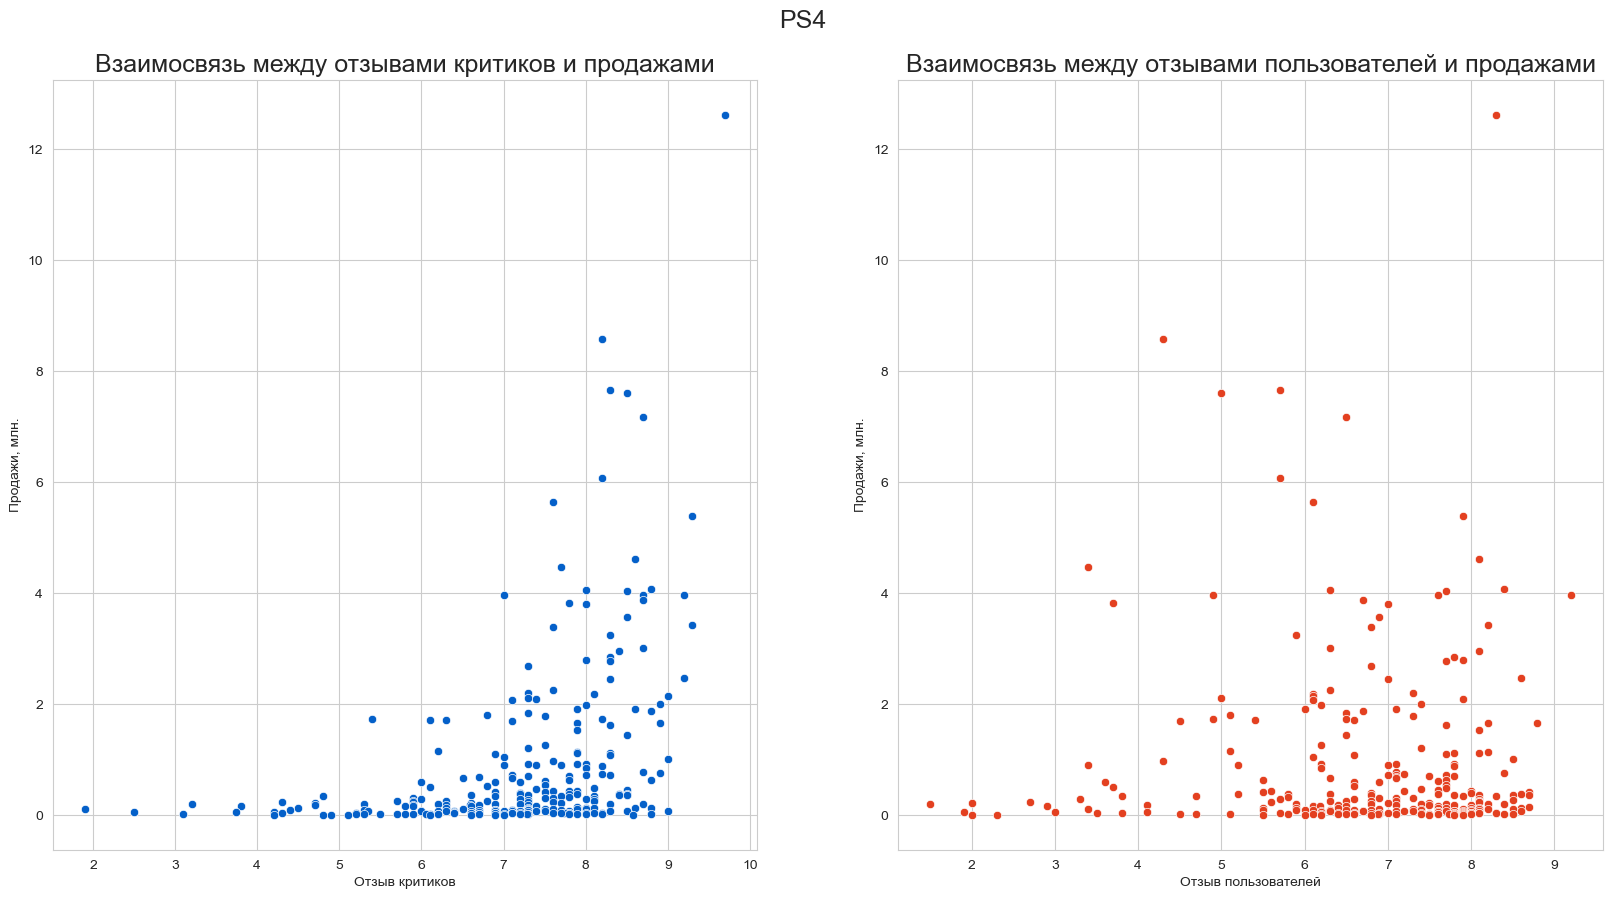

In [24]:
def plot_scatter(condition):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.suptitle(condition.upper(), fontsize=18, y=0.95)

    sns.scatterplot(data=from_2013[from_2013['platform']==condition], x='critic_score', y='total_sales', color=colors[0], ax=axs[0])
    axs[0].set_title('Взаимосвязь между отзывами критиков и продажами', fontsize=18)
    axs[0].set_xlabel('Отзыв критиков')
    axs[0].set_ylabel('Продажи, млн.')

    sns.scatterplot(data=from_2013[from_2013['platform']==condition], x='user_score', y='total_sales', color=colors[1], ax=axs[1])
    axs[1].set_title('Взаимосвязь между отзывами пользователей и продажами', fontsize=18)
    axs[1].set_xlabel('Отзыв пользователей')
    axs[1].set_ylabel('Продажи, млн.')

    plt.show()
    
plot_scatter('PS4')

In [25]:
def print_cor(condition):
    print('Платформа', condition)
    cor = from_2013[from_2013['platform']==condition]['total_sales'].corr(from_2013[from_2013['platform']==condition]['critic_score'])
    print('корреляция между отзывами критиков и продажами:', round(cor,3))
    cor = from_2013[from_2013['platform']==condition]['total_sales'].corr(from_2013[from_2013['platform']==condition]['user_score'])
    print('корреляция между отзывами пользователей и продажами:', round(cor,3))

In [26]:
print_cor('PS4')

Платформа PS4
корреляция между отзывами критиков и продажами: 0.403
корреляция между отзывами пользователей и продажами: -0.033


По графику можно заметить, что отзывы критиков в той или иной степени влияют на продаваемость игр, что нельзя сказать про отзывы пользователей. Кроме того, корреляция между отзывами пользователей и продажами составляет -0.031, между двумя переменными нет линейной корреляции.

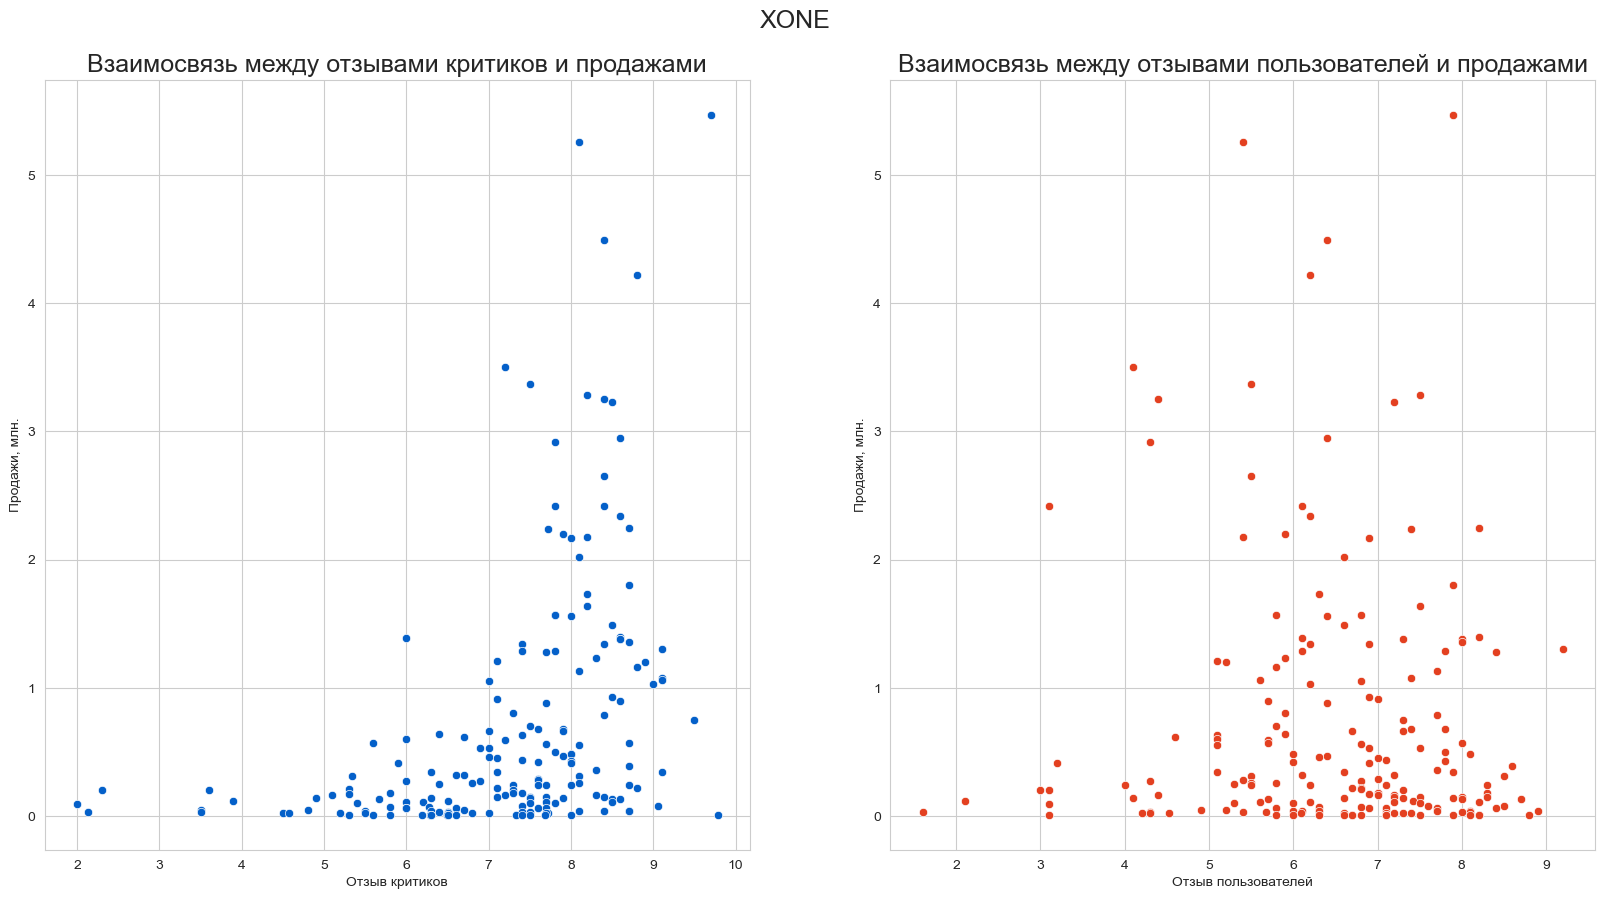

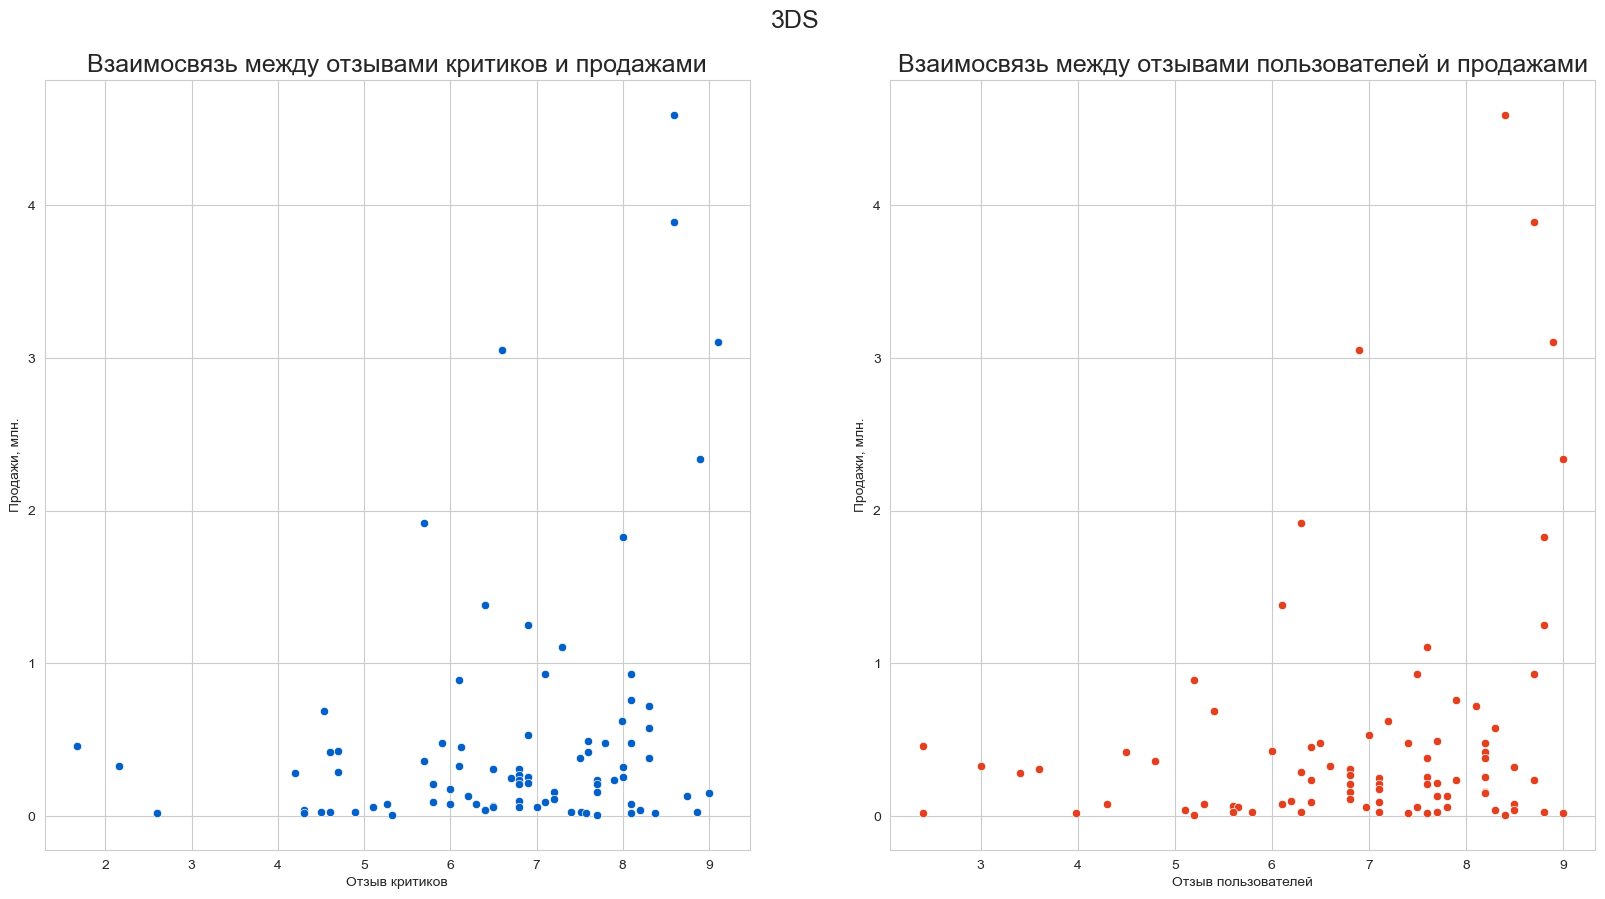

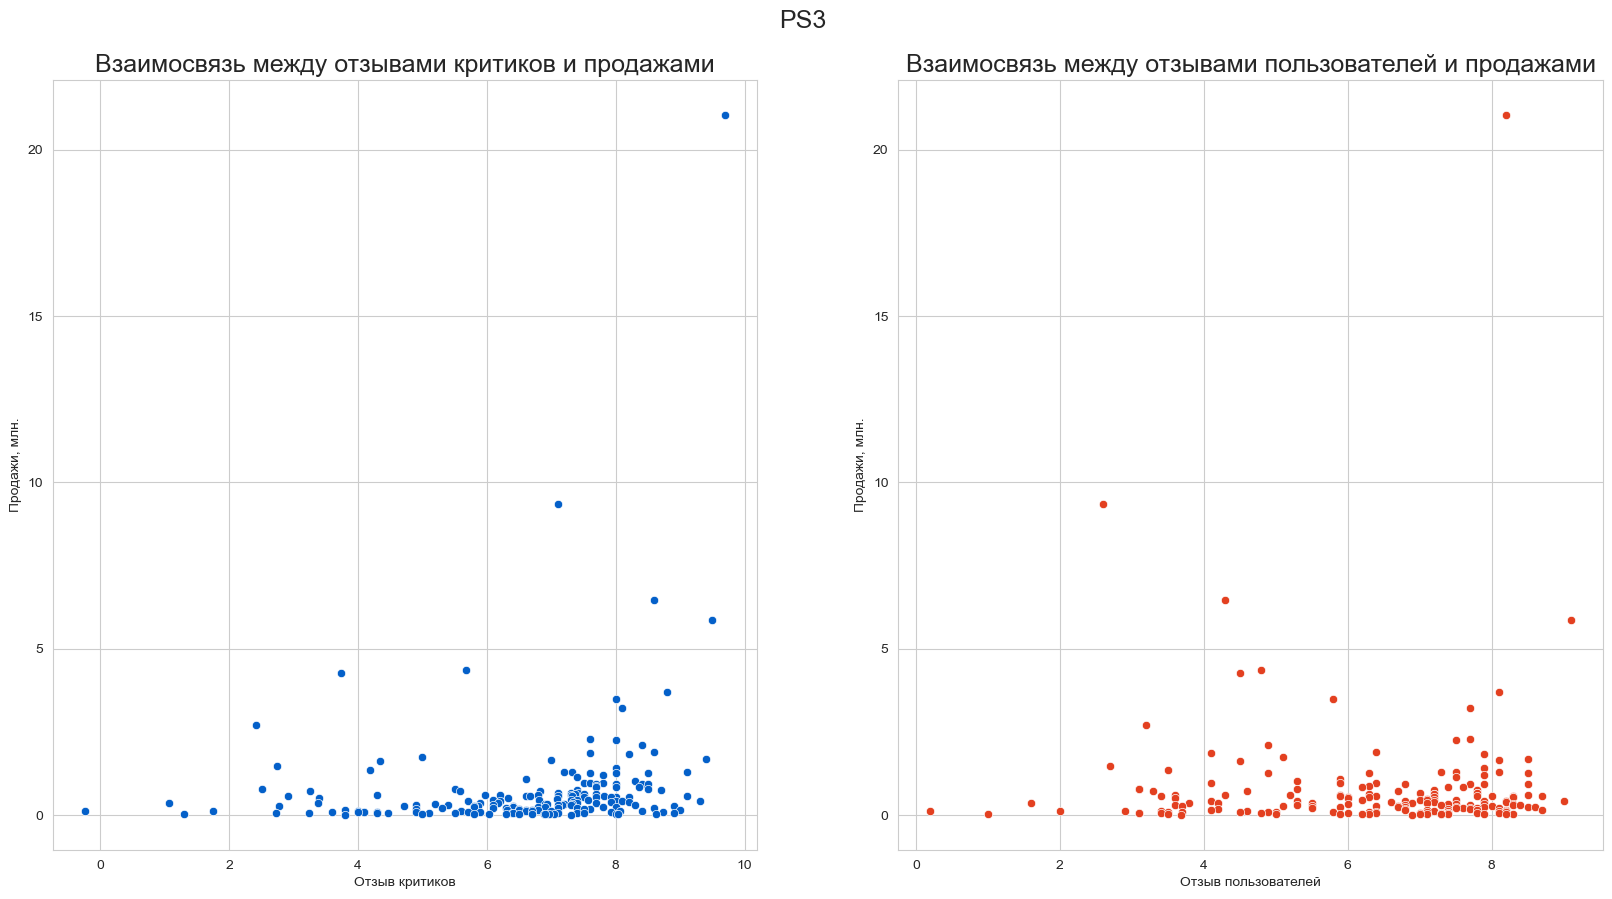

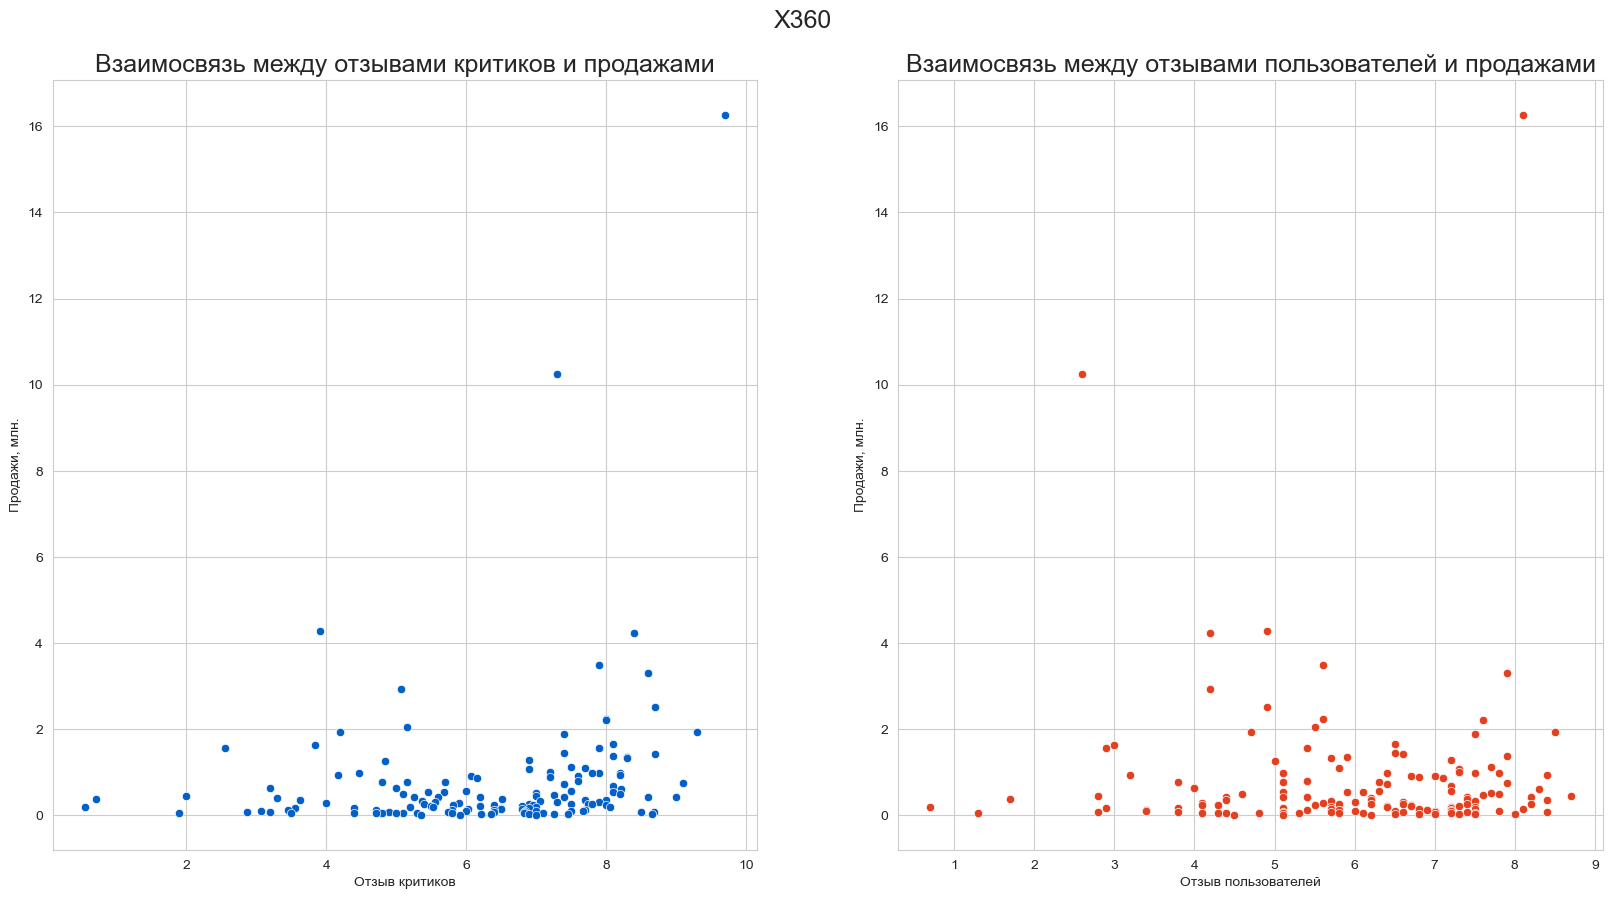

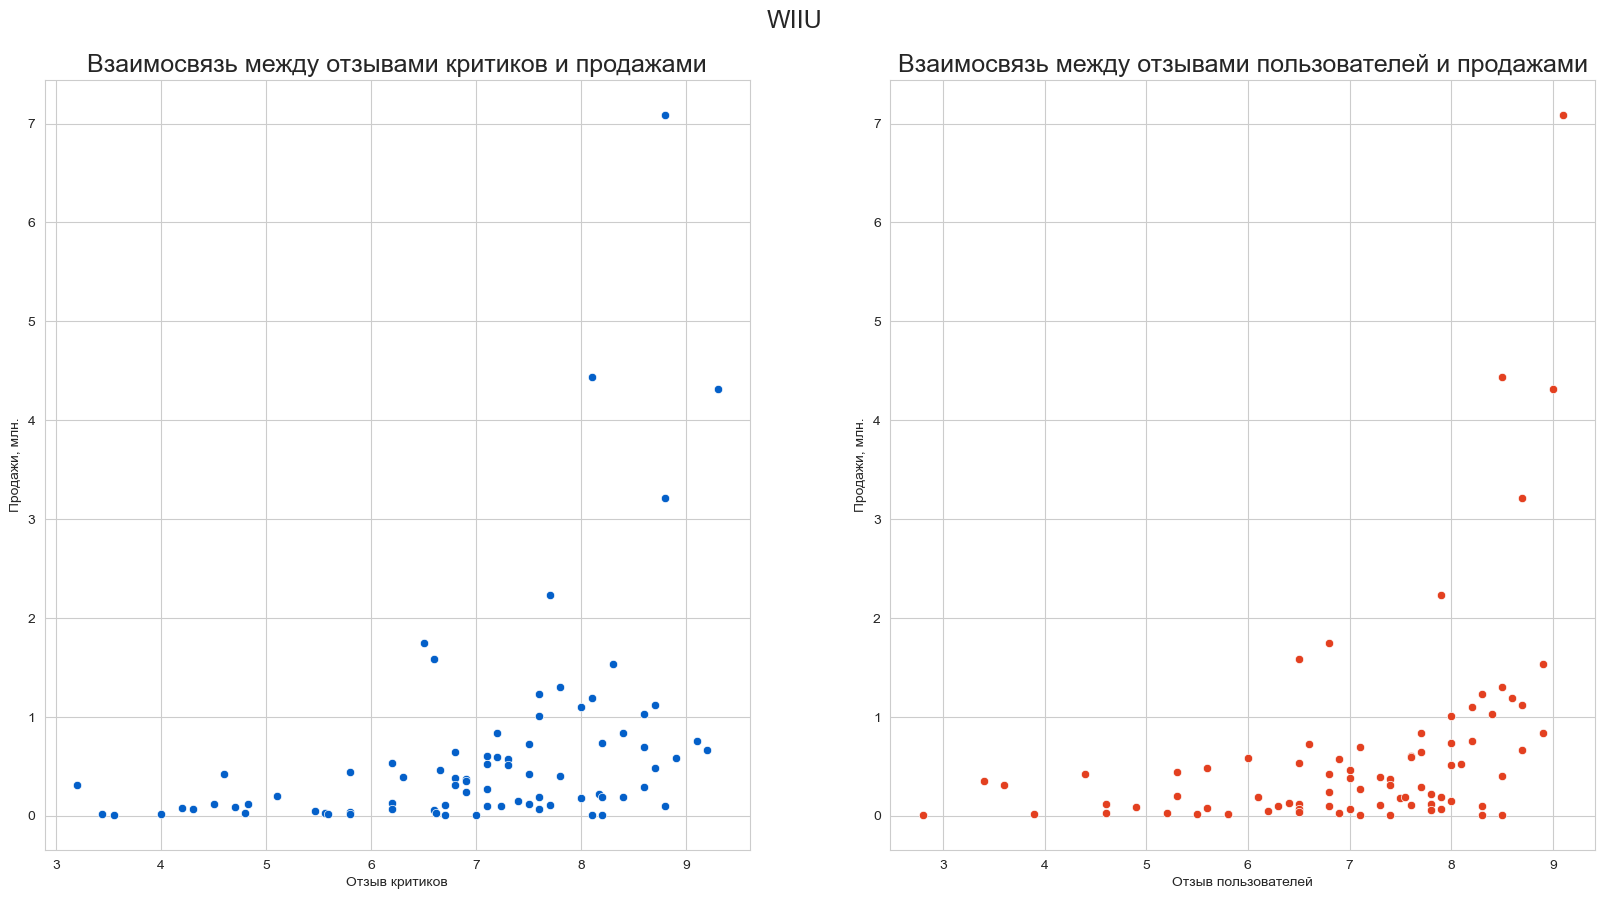

In [27]:
for i in ['XOne', '3DS', 'PS3', 'X360', 'WiiU']:
    plot_scatter(i)

In [28]:
for i in ['XOne', '3DS', 'PS3', 'X360', 'WiiU']:
    print_cor(i)

Платформа XOne
корреляция между отзывами критиков и продажами: 0.406
корреляция между отзывами пользователей и продажами: -0.061
Платформа 3DS
корреляция между отзывами критиков и продажами: 0.272
корреляция между отзывами пользователей и продажами: 0.258
Платформа PS3
корреляция между отзывами критиков и продажами: 0.203
корреляция между отзывами пользователей и продажами: 0.006
Платформа X360
корреляция между отзывами критиков и продажами: 0.229
корреляция между отзывами пользователей и продажами: -0.012
Платформа WiiU
корреляция между отзывами критиков и продажами: 0.396
корреляция между отзывами пользователей и продажами: 0.416


Результаты схожи с результатами для PS4. Отзывы критиков минимально влияют на продаваемость игр, а отзывы пользователей вовсе не оказывают влияния. Хотя существуют исключения. Например, для Wii U отзывы пользователей и продажи коррелируют больше, чем отзывы критиков.

In [29]:
values_genre = from_2013['genre'].value_counts()

fig = go.Figure(data=[go.Pie(labels=values_genre.index, values=values_genre.values)])
fig.update_layout(title='Жанры', width=900, height=700)
fig.update_traces(textposition='inside', textinfo='percent+label+text')
fig.show() 

Игры жанра Action составляют примерно 34% всех игр.  

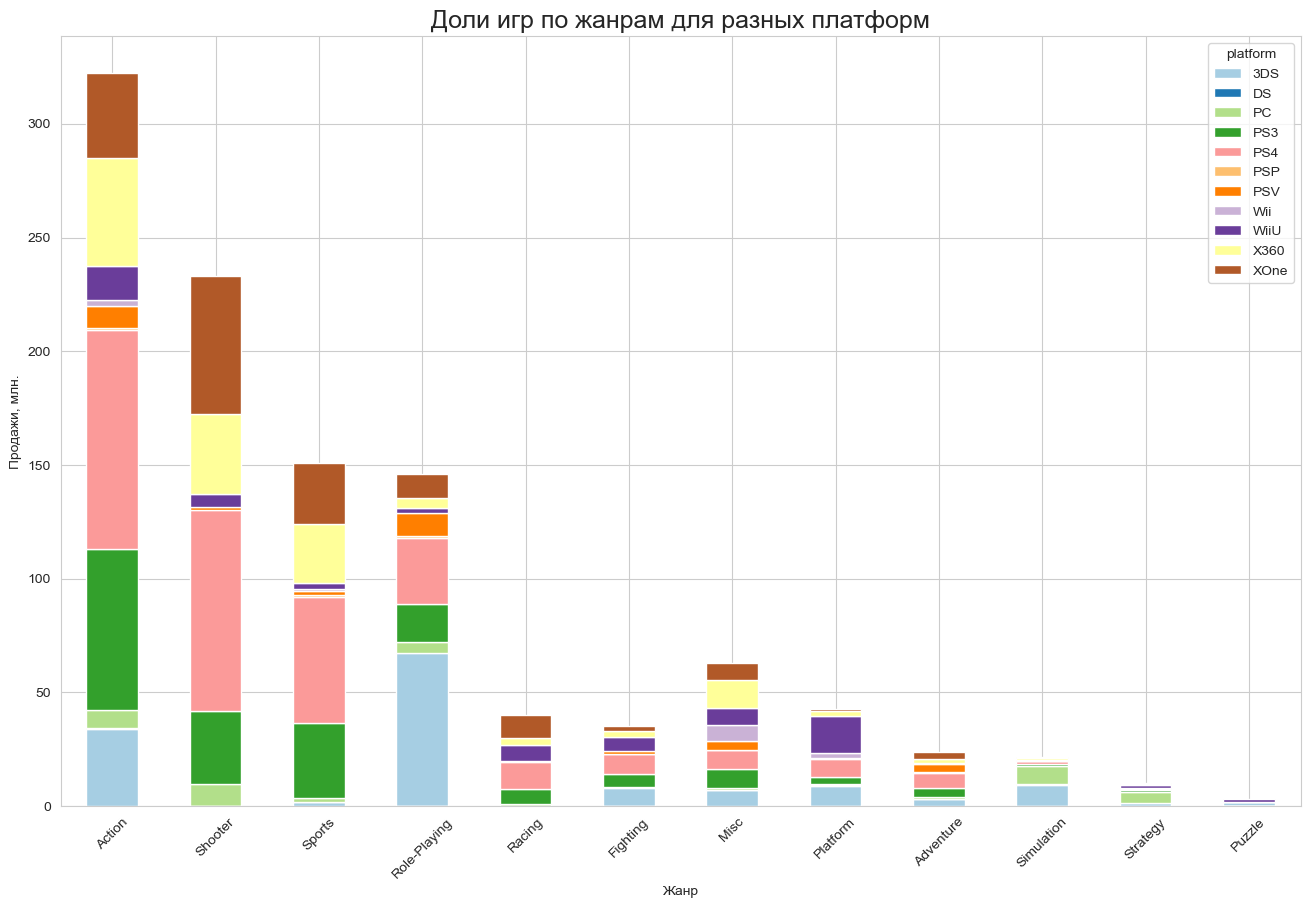

In [30]:
by_genre = from_2013.pivot_table(index = 'genre', columns = 'platform', values = 'total_sales', aggfunc='sum')

fig, ax = plt.subplots(figsize=(16, 10))

by_genre.sort_values(by='PS4', ascending=False).plot(kind='bar',stacked=True, ax=ax, cmap='Paired')

plt.title('Доли игр по жанрам для разных платформ', fontsize=18)
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн.')
plt.xticks(rotation=45)
plt.show()

- Больше всего продаж у игр жанра Action, Shooter, Sports и Role-Playing;

- Несмотря на сравнительно большое количество игр жанра Adventure, их продажи не так высоки;

- Игры жанра Action хорошо продавались на PS3 и PS4. В то время как Shooter популярны на PS4 и XOne. Игры жанра RPG хорошо продавались на 3DS.

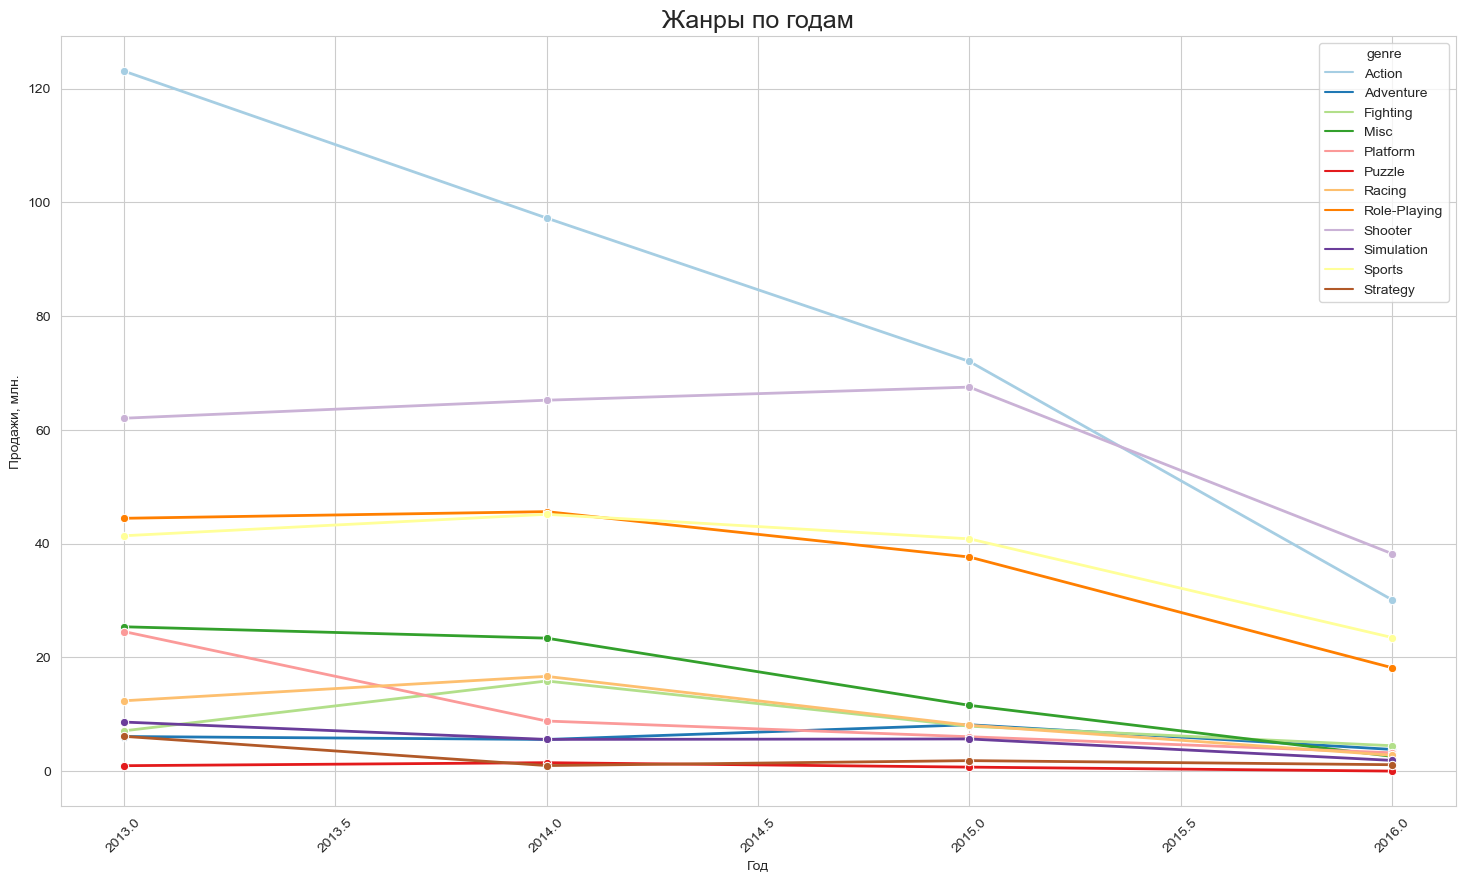

In [31]:
sales_by_genre = (pd.pivot_table(from_2013, values='total_sales', index={'year_of_release', 'genre'}, aggfunc='sum')
                     .reset_index())

plt.figure(figsize=(18,10))

sns.lineplot(data=sales_by_genre, x="year_of_release", y="total_sales", 
             hue="genre", marker='o', palette=sns.color_palette('Paired', 12), lw=2)

plt.title('Жанры по годам', fontsize=18)
plt.xlabel('Год')
plt.ylabel('Продажи, млн.')
plt.xticks(rotation=45)
plt.show()

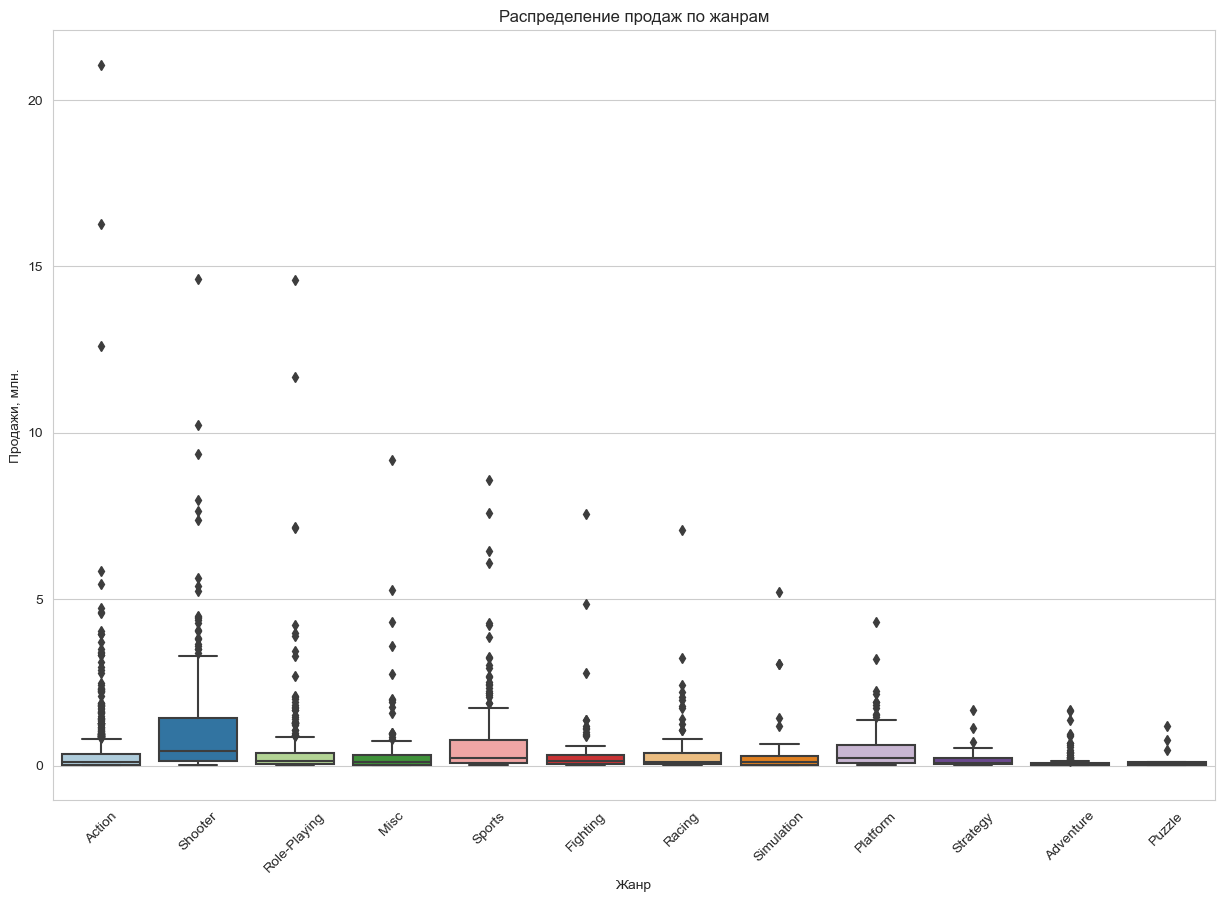

In [32]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

ax = sns.boxplot(x='genre', y='total_sales', data=from_2013, palette=sns.color_palette('Paired', 12))

plt.title('Распределение продаж по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн.')
plt.xticks(rotation=45)
plt.show()

- В 2016 году игры жанра Shooter вышли на 1ое место, обогнав по суммарным продажам Action игры. 

- В 2015 году Sports обогнали Role-Playing по суммарным продажам. Это может быть связано с тем, что игры данного жанра популярны на Nintendo 3DS, но последние несколько лет эта платформа не так актуальна, как PS4 и XOne.

- Если смотреть по медианным продажам, то Shooter игры показывают самый лучший результат. Также Sports и Platform приносят стабильно высокий доход.

## Портрет пользователя каждого региона

<Axes: xlabel='platform'>

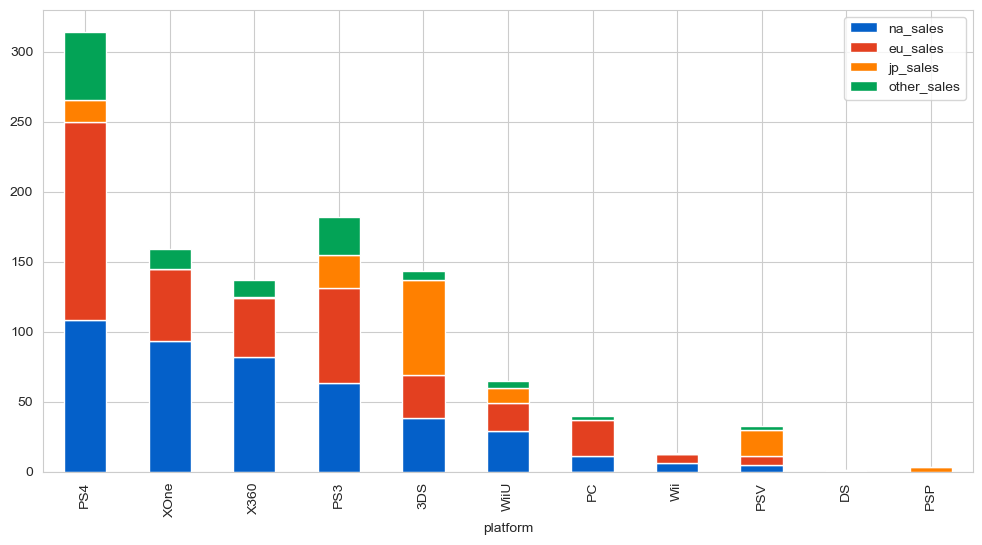

In [33]:
platform_by_region = from_2013.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
platform_by_region.sort_values(by='na_sales', ascending=False).plot(kind='bar',stacked=True, figsize=(12,6), color=colors)

In [34]:
platform_by_region.apply(lambda x: x / x.sum(), axis=0).style.format("{:.1%}")

- Playstation популярны во всем мире;

- Если учитывать только 3 региона (Северная Америка, Европа, Япония), то Европейские пользователи больше всех предпочитают PS (52%);

- В Америке игроки предпочитают консоли от Microsoft (40%);

- В Японии предпочитают Nintendo (48%).

<Axes: xlabel='genre'>

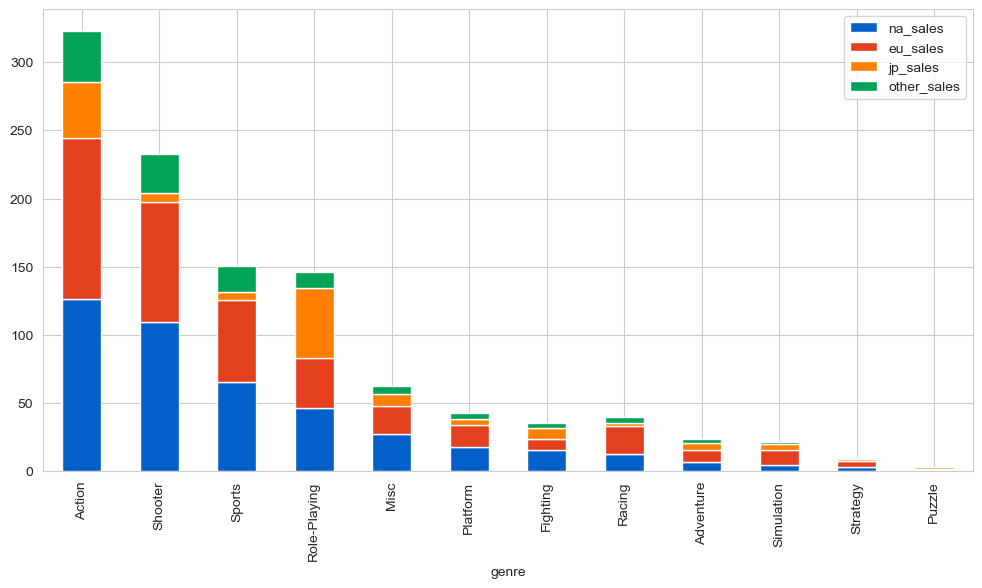

In [35]:
genre_by_region = from_2013.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
genre_by_region.sort_values(by='na_sales', ascending=False).plot(kind='bar',stacked=True, figsize=(12,6), color=colors)

In [36]:
genre_by_region.apply(lambda x: x / x.sum(), axis=0).style.format("{:.1%}")

Игроки из Европы и Северной Америки предпочитают игры жанра Action, Shooter, Sports. В Японии больше любят играть в RPG.

<Axes: xlabel='rating'>

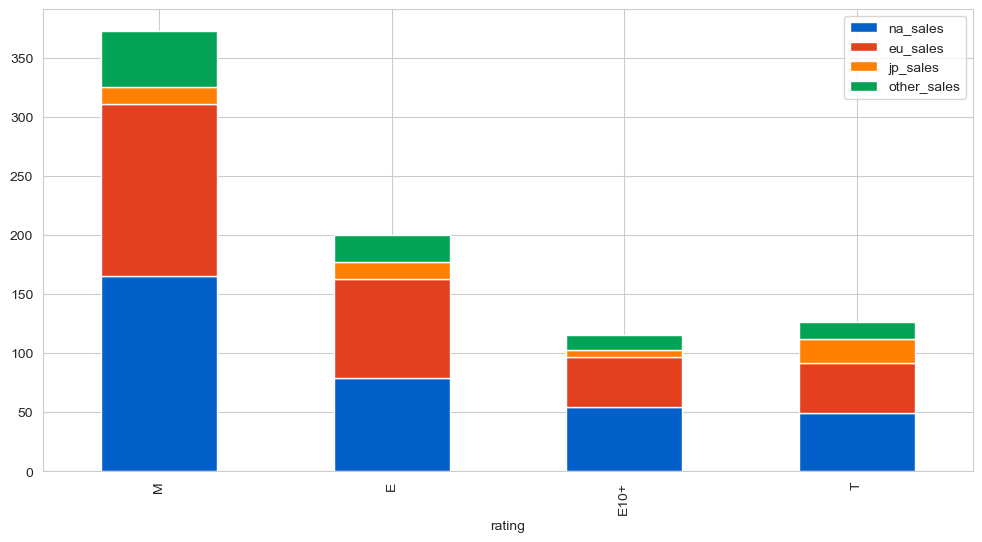

In [37]:
rating_by_region = from_2013.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].agg('sum')
rating_by_region.sort_values(by='na_sales', ascending=False).plot(kind='bar',stacked=True, figsize=(12,6), color=colors)

In [38]:
rating_by_region.apply(lambda x: x / x.sum(), axis=0).style.format("{:.1%}")

Т.к. игры жанра Action и Shooter обычно имеют более высокий рейтинг, и эти жанры больше популярны в Америке и Европе, то этим можно объяснить высокие продажи игр с высоким рейтингом в данных регионах.

## Проверка гипотез

Если данные имеют не нормальное распределение, то стоит использовать непараметрический тест Уилкоксона-Манна-Уитни.

Уровень значимости = 0.05

In [39]:
def check_norm(sample):
    
    alpha = 0.05  

    results = st.shapiro(sample)
    p_value = results[1]  

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 
        
def t_test(sample1, sample2):
    
    alpha = 0.05 # уровень статистической значимости
    # если p-value окажется меньше него, отвергнем гипотезу

    results = st.ttest_ind(sample1, sample2, alternative='two-sided')

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

def Mann_Whitney(sample1, sample2):
    
    alpha = 0.05  # критический уровень статистической значимости

    results = st.mannwhitneyu(sample1, sample2)

    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
        ) 

H0: Различия между средними пользовательскими рейтингами платформ Xbox One и PC отсутствуют.

Ha: Различия в среднем между группами есть.

In [40]:
sample_1 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['platform']=='XOne']['user_score']))
sample_2 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['platform']=='PC']['user_score']))

check_norm(sample_1)
check_norm(sample_2)

Отвергаем нулевую гипотезу: распределение не нормально
Отвергаем нулевую гипотезу: распределение не нормально


Используем непараметрический тест Уилкоксона-Манна-Уитни:

In [41]:
Mann_Whitney(sample_1, sample_2)

p-значение:  0.6608639553049387
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Не удалось отвергнуть нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H0: Различия между средними пользовательскими рейтингами жанров Action и Sports отсутствуют.

Ha: Различия в среднем между группами есть.

In [42]:
sample_1 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['genre']=='Action']['user_score']))
sample_2 = list(filter(lambda item: pd.isna(item)==False, from_2013[from_2013['genre']=='Sports']['user_score']))

check_norm(sample_1)
check_norm(sample_2)

Отвергаем нулевую гипотезу: распределение не нормально
Отвергаем нулевую гипотезу: распределение не нормально


Используем непараметрический тест Уилкоксона-Манна-Уитни:

In [43]:
Mann_Whitney(sample_1, sample_2)

p-значение:  6.723604170187621e-24
Отвергаем нулевую гипотезу: разница статистически значима


Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

## Общий вывод

На основе анализа предоставленных данных 2013-2016гг. нам удалось выявить:

- Оценки критиков минимально влияют на продажи, а оценки пользователей вовсе не оказывают никакого влияния. Хотя существуют исключения. Например, для Wii U отзывы пользователей (0.419) и продажи коррелируют больше, чем отзывы критиков (0.399)

- За весь период начиная с 2013г. X360, PS4, PS3, XOne, WiiU, Wii и DS приносят стабильно высокий доход (медиана ~200 000 копий)

- Если судить по графику суммарных продаж по платформам, то PlayStation 4 и Xbox One являются самыми потенциально прибыльными платформами

- Если смотреть по медианным продажам, то Shooter игры показывают самый лучший результат. Также Sports и Platform приносят стабильно высокий доход

- Европейские пользователи больше всех предпочитают PS (доля игроков в регионе 52%). В Америке игроки предпочитают консоли от Microsoft (доля игроков в регионе 40%). В Японии любят консоли от Nintendo (доля игроков в регионе 48%)

- В Америке и Европе предпочитают игры жанра Action и Shooters (доля игроков в регионах > 50%). Как правило, игры этих жанров имеют более высокий рейтинг. В Японии больше любят RPG (доля игроков в регионе 36%)

Также мы проверили некоторые гипотезы и выявили, что при alpha = 5%:

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

- Средние пользовательские рейтинги жанров Action и Sports разные. 